# pandas的merge语法

pandas如何实现dataframe的merge

pandas的merge，相当于sql的join语法，将不同的表按照key关联到一个表

DataFrame.merge(right, how='inner', on=None, left_on=None, right_on=None, left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=None, indicator=False, validate=None)  
**merge语法：**

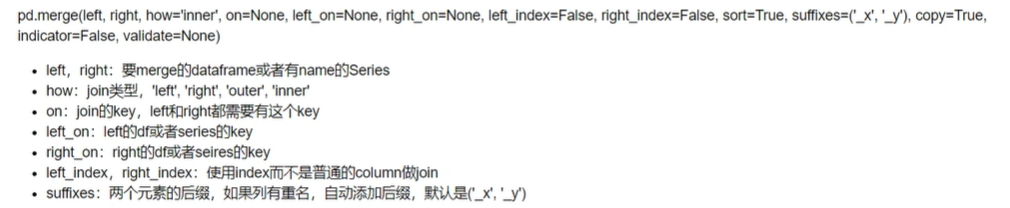

参考文档：
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html

本次讲解提纲：
1. 电影数据的join实例
2. 理解merge的一对一、一对多、多对多的数量的对齐关系
3. 理解left join，right join，outer join, inner join的区别
5. 如果出现非key的字段重名怎么办

## 电影评分数据集的join实例

电影评分数据集

是推荐系统研究的很好的数据集  
这个数据集文件存在'./data/movielens-1m'  

包含三个文件：
1. 用户对于电影的评分数据 ratings.dat
2. 用户本身数据信息 users.dat
3. 电影本身的数据 movies.dat

可以关联三个表，得到一个完整的大表

数据集官方网址：https://grouplens.org/datasets/movielens/

In [1]:
import pandas as pd

In [2]:
df_ratings = pd.read_csv(
    './data/movielens-1m/ratings.dat',
    sep='::',  # 防止被读取成正则表达式 才有了下面的engine='python'
    engine='python',
    # header=None,
    names='UserId::MovieId::Rating::Timestamp'.split("::")
)

In [9]:
df_ratings.head()

,UserId,MovieId,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
df_users = pd.read_csv(
    './data/movielens-1m/users.dat',
    sep='::',  # 防止被读取成正则表达式 才有了下面的engine='python'
    engine='python',
    # header=None,
    names='UserId::Gender::Age::Occupation::Zip-Code'.split("::")
)

In [5]:
df_users.head()

,UserId,Gender,Age,Occupation,Zip-Code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
df_movies = pd.read_csv(
    './data/movielens-1m/movies.dat',
    sep='::',  # 防止被读取成正则表达式 才有了下面的engine='python'
    engine='python',
    # header=None,
    names='MovieId::Title::Genres'.split("::")
)

In [7]:
df_movies.head()

,MovieId,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
df_ratings_users = pd.merge(
    df_ratings,
    df_users,
    left_on='UserId',
    right_on='UserId',
    how='inner'
)

In [11]:
df_ratings_users

,UserId,MovieId,Rating,Timestamp,Gender,Age,Occupation,Zip-Code
0,1,1193,5,978300760,F,1,10,48067
1,1,661,3,978302109,F,1,10,48067
2,1,914,3,978301968,F,1,10,48067
3,1,3408,4,978300275,F,1,10,48067
4,1,2355,5,978824291,F,1,10,48067
...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,M,25,6,11106
1000205,6040,1094,5,956704887,M,25,6,11106
1000206,6040,562,5,956704746,M,25,6,11106
1000207,6040,1096,4,956715648,M,25,6,11106


In [12]:
df_ratings_user_movie = pd.merge(
    df_ratings_users,
    df_movies,
    left_on='MovieId',
    right_on='MovieId',
    how='inner',
)

In [13]:
df_ratings_user_movie

,UserId,MovieId,Rating,Timestamp,Gender,Age,Occupation,Zip-Code,Title,Genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...,...,...,...,...
1000204,5949,2198,5,958846401,M,18,17,47901,Modulations (1998),Documentary
1000205,5675,2703,3,976029116,M,35,14,30030,Broken Vessels (1998),Drama
1000206,5780,2845,1,958153068,M,18,17,92886,White Boys (1999),Drama
1000207,5851,3607,5,957756608,F,18,20,55410,One Little Indian (1973),Comedy|Drama|Western


## 理解merge时数量的对齐关系

以下关系要正确理解：

- one-to-one 一对一关系，关联的key都是唯一的
    - 比如(学号，姓名)merge(学号，年龄)
    - 结果条数为 1 * 1
- one-to-many 一对多关系，左边唯一key，右边不唯一key
    - 比如(学号，姓名)merge(学号，[语文成绩， 数学成绩，英语成绩])
    - 结果条数为1 * n
- many-to-many 多对多关系，左边右边都不是唯一的
    - 比如 (学号，[篮球，足球，乒乓球])merge(学号，[语文成绩， 数学成绩，英语成绩])
    - 结果条数为m * n

### 一对一关系的merge

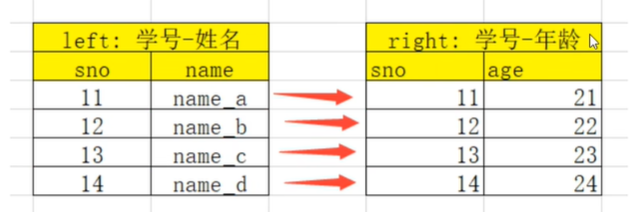

In [14]:
left = pd.DataFrame(
    {
        'sno': [11, 12, 13, 14],
        'name': ['a', 'b', 'c', 'd'],
    }
)
left

,sno,name
0,11,a
1,12,b
2,13,c
3,14,d


In [15]:
right = pd.DataFrame(
    {
        'sno': [11, 12, 13, 14],
        'age': ['21', '22', '23', '24'],
    }
)
right

,sno,age
0,11,21
1,12,22
2,13,23
3,14,24


In [17]:
pd.merge(
    left=left,
    right=right,
    on='sno'
)

,sno,name,age
0,11,a,21
1,12,b,22
2,13,c,23
3,14,d,24


### 一对多关系的merge

注意，数据会被复制

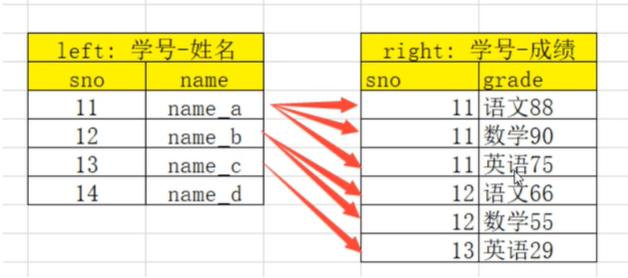

In [18]:
left = pd.DataFrame(
    {
        'sno': [11, 12, 13, 14],
        'name': ['a', 'b', 'c', 'd'],
    }
)
left

,sno,name
0,11,a
1,12,b
2,13,c
3,14,d


In [19]:
right = pd.DataFrame(
    {
        'sno': [11, 11, 11, 12, 12, 13],
        'grade': ['语文88', '数学90', '英语75', '语文66', '数学55', '英语29'],
    }
)
right

,sno,grade
0,11,语文88
1,11,数学90
2,11,英语75
3,12,语文66
4,12,数学55
5,13,英语29


In [20]:
# 数据以多的一边为准
pd.merge(
    left, 
    right,
    on='sno'
)

,sno,name,grade
0,11,a,语文88
1,11,a,数学90
2,11,a,英语75
3,12,b,语文66
4,12,b,数学55
5,13,c,英语29


### 多对多的merge关系

注意：结果数量会出现乘法

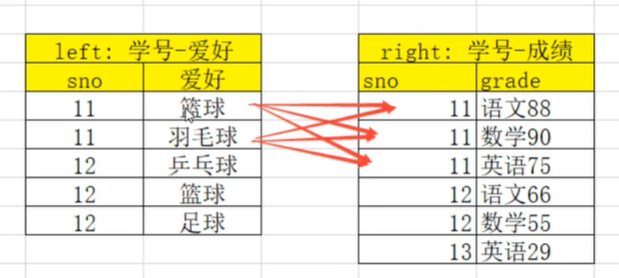

In [21]:
left = pd.DataFrame(
    {
        'sno': [11, 11, 12, 12, 12],
        'hobby': ['篮球', '羽毛球', '乒乓球', '篮球', '足球'],
    }
)
left

,sno,hobby
0,11,篮球
1,11,羽毛球
2,12,乒乓球
3,12,篮球
4,12,足球


In [22]:
right = pd.DataFrame(
    {
        'sno': [11, 11, 11, 12, 12, 13],
        'grade': ['语文88', '数学90', '英语75', '语文66', '数学55', '英语29'],
    }
)
right

,sno,grade
0,11,语文88
1,11,数学90
2,11,英语75
3,12,语文66
4,12,数学55
5,13,英语29


In [23]:
pd.merge(
    left,
    right,
    on='sno'
)

,sno,hobby,grade
0,11,篮球,语文88
1,11,篮球,数学90
2,11,篮球,英语75
3,11,羽毛球,语文88
4,11,羽毛球,数学90
5,11,羽毛球,英语75
6,12,乒乓球,语文66
7,12,乒乓球,数学55
8,12,篮球,语文66
9,12,篮球,数学55


## 理解left join,right join,inner join,outer join的区别

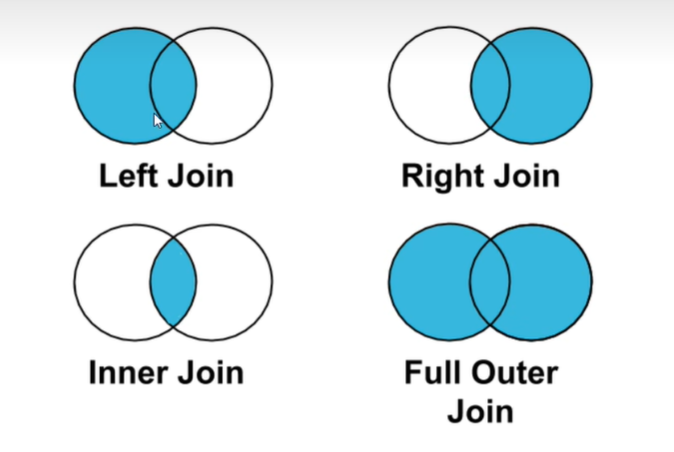

In [24]:
left = pd.DataFrame(
    {
        'Key': ['k0', 'k1', 'k2', 'k3'],
        'A': ['A0', 'A1', 'A2', 'A3'],
        'B': ['B0', 'B1', 'B2', 'B3'],
    }
)
left

,Key,A,B
0,k0,A0,B0
1,k1,A1,B1
2,k2,A2,B2
3,k3,A3,B3


In [25]:
right = pd.DataFrame(
    {
        'Key': ['k0', 'k1', 'k4', 'k5'],
        'C': ['C0', 'C1', 'C2', 'C3'],
        'D': ['D0', 'D1', 'D2', 'D3'],
    }
)
right

,Key,C,D
0,k0,C0,D0
1,k1,C1,D1
2,k4,C2,D2
3,k5,C3,D3


### inner join 默认

左边和右边的key都有才会出现在结果里

In [26]:
pd.merge(
    left,
    right,
    how='inner',
)

,Key,A,B,C,D
0,k0,A0,B0,C0,D0
1,k1,A1,B1,C1,D1


### left join

左边的都会出现在结果里，右边的无法匹配则为NaN

In [27]:
pd.merge(
    left,
    right,
    how='left',
)

,Key,A,B,C,D
0,k0,A0,B0,C0,D0
1,k1,A1,B1,C1,D1
2,k2,A2,B2,NaN,NaN
3,k3,A3,B3,NaN,NaN


### right join 右边的都会出现在结果里，左边的无法匹配则为NaN

In [29]:
pd.merge(
    left,
    right,
    how='right',
)

,Key,A,B,C,D
0,k0,A0,B0,C0,D0
1,k1,A1,B1,C1,D1
2,k4,NaN,NaN,C2,D2
3,k5,NaN,NaN,C3,D3


### outer join 左边右边的都是出现在结果里，如果无法匹配则为Nan

In [30]:
pd.merge(
    left,
    right,
    how='outer',
)

,Key,A,B,C,D
0,k0,A0,B0,C0,D0
1,k1,A1,B1,C1,D1
2,k2,A2,B2,NaN,NaN
3,k3,A3,B3,NaN,NaN
4,k4,NaN,NaN,C2,D2
5,k5,NaN,NaN,C3,D3


## 如果出现非key字段重名了怎么办

In [31]:
left = pd.DataFrame(
    {
        'Key': ['k0', 'k1', 'k2', 'k3'],
        'A': ['A0', 'A1', 'A2', 'A3'],
        'B': ['B0', 'B1', 'B2', 'B3'],
    }
)
right = pd.DataFrame(
    {
        'Key': ['k0', 'k1', 'k4', 'k5'],
        'A': ['A01', 'A11', 'A21', 'A31'],
        'D': ['D0', 'D1', 'D2', 'D3'],
    }
)


In [32]:
left

,Key,A,B
0,k0,A0,B0
1,k1,A1,B1
2,k2,A2,B2
3,k3,A3,B3


In [33]:
right

,Key,A,D
0,k0,A01,D0
1,k1,A11,D1
2,k4,A21,D2
3,k5,A31,D3


In [35]:
pd.merge(left,right,on='Key')

,Key,A_x,B,A_y,D
0,k0,A0,B0,A01,D0
1,k1,A1,B1,A11,D1


In [39]:
pd.merge(left,right,on='Key',suffixes=('_left', '_right'))

,Key,A_left,B,A_right,D
0,k0,A0,B0,A01,D0
1,k1,A1,B1,A11,D1


In [40]:
pd.merge(left,right,on='Key',suffixes=('_left', '_right'), how='outer')

,Key,A_left,B,A_right,D
0,k0,A0,B0,A01,D0
1,k1,A1,B1,A11,D1
2,k2,A2,B2,NaN,NaN
3,k3,A3,B3,NaN,NaN
4,k4,NaN,NaN,A21,D2
5,k5,NaN,NaN,A31,D3
